## vanilla-DNN

Author: Justin Tan

Vanilla neural network. Do anything from MNIST to signal classification.

Update 20/03: Added batch normalization, TensorBoard visualization

Update 19/06: Added cosine annealing, exponential moving average

Update 22/09: Moved input pipeline to Tensorflow dataset API - placeholder comparison w/ tfrecords

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import glob, time, os
import selu
from diagnostics import *

class config(object):
    # Set network parameters
    mode = 'cfd-selu'
    channel = 'B2Xdy'
    keep_prob = 0.7
    num_epochs = 128
    batch_size = 256
    n_layers = 6
    hidden_layer_nodes = [1024, 1024, 512, 512, 256, 256]
    ema_decay = 0.999
    learning_rate = 2e-5
    cycles = 3 # Number of annealing cycles
    n_classes = 2
    builder = 'selu'

class directories(object):
    train = '/data/projects/punim0011/jtan/spark/spark2tf/cfd_b2dy_By_train.parquet'# '/home/jtan/gpu/jtan/spark/spark2tf/example_train.tfrecords'
    test = '/data/projects/punim0011/jtan/spark/spark2tf/cfd_b2dy_By_test.parquet'#'/home/jtan/gpu/jtan/spark/spark2tf/example_test.tfrecords'
    val = '/data/projects/punim0011/jtan/spark/spark2tf/cfd_b2dy_By_val.parquet'#'/home/jtan/gpu/jtan/spark/spark2tf/example_test.tfrecords'
    tensorboard = 'tensorboard'
    checkpoints = 'b2dy_cfd'

def balanced_sample(df, uspl=True, seed=42):
    features_l = [df[df['labels']==l].copy() for l in list(set(df['labels'].values))]
    lsz = [f.shape[0] for f in features_l]
    return pd.concat([f.sample(n = (min(lsz) if uspl else max(lsz)), replace = (not uspl)).copy() for f in features_l], axis=0 ).sample(frac=1, random_state=seed) 

architecture = '{} - {} | Layers: {} | Dropout: {} | Base LR: {} | Epochs: {}'.format(
    config.channel, config.mode, config.n_layers, config.keep_prob, config.learning_rate, config.num_epochs)
get_available_gpus()

def load_parquet(datasetName, subsample=False, dropFrac=0.75):
    from sklearn.model_selection import train_test_split
    
    excludeFeatures = ['labels', 'mbc', 'deltae', 'daughterInvM', 'nCands', 'evtNum', 'MCtype', 'channel']
    dataset = pq.ParquetDataset(datasetName)
    pdf = dataset.read(nthreads=4).to_pandas()
    pdf = pdf.drop(pdf[pdf['labels']==1].sample(frac=dropFrac).index) if subsample else pdf.sample(frac=1)
    features = pdf.drop(excludeFeatures, axis=1)
    labels = pdf['labels'].astype(np.int32)
    
    return features.values.astype(np.float32), labels.values, pdf

Available GPUs:
['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']


In [2]:
features, labels, pdf = load_parquet(directories.train, subsample=True)
featuresTest, labelsTest, pdf1 = load_parquet(directories.test)
config.nTrainExamples, config.nFeatures = features.shape[0], features.shape[-1]
config.steps_per_epoch = features.shape[0] // config.batch_size

In [3]:
def dataset_placeholder(features_placeholder, labels_placeholder, batchSize, numEpochs, training=True):  
    dataset = tf.contrib.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
    dataset = dataset.shuffle(buffer_size=16384)
    dataset = dataset.batch(batchSize)
    dataset = dataset.repeat(numEpochs) if training else dataset

    return dataset

def dataset_train(dataDirectory, batchSize, numEpochs, nFeatures, training=True):
    filenames = glob.glob('{}/part*'.format(dataDirectory))
    dataset = tf.contrib.data.TFRecordDataset(filenames)

    # Extract data from `tf.Example` protocol buffer
    def parser(record, batchSize=128):
        keys_to_features = {
            "features": tf.FixedLenFeature([nFeatures], tf.float32),
            "labels": tf.FixedLenFeature((), tf.float32,
            default_value=tf.zeros([], dtype=tf.float32)),
        }
        parsed = tf.parse_single_example(record, keys_to_features)
        label = tf.cast(parsed['labels'], tf.int32)

        return parsed['features'], label

    # Transform into feature, label tensor pair
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=16384)
    dataset = dataset.batch(batchSize)
    dataset = dataset.repeat(numEpochs) if training else dataset

    return dataset

def dense_builder(x, shape, name, keep_prob, training=True, actv=tf.nn.relu):
    init=tf.contrib.layers.xavier_initializer()
    kwargs = {'center': True, 'scale': True, 'training': training, 'fused': True, 'renorm': True}

    with tf.variable_scope(name, initializer=init) as scope:
        layer = tf.layers.dense(x, units=shape[1], activation=actv)
        bn = tf.layers.batch_normalization(layer, **kwargs)
        layer_out = tf.layers.dropout(bn, keep_prob, training=training)

    return layer_out

def selu_builder(x, shape, name, keep_prob, training=True):
    init = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')

    with tf.variable_scope(name) as scope:
        W = tf.get_variable("weights", shape = shape, initializer=init)
        b = tf.get_variable("biases", shape = [shape[1]], initializer=tf.random_normal_initializer(stddev=0.1))
        actv = selu.selu(tf.add(tf.matmul(x, W), b))
        layer_output = selu.dropout_selu(actv, rate=1-keep_prob, training=training)

    return layer_output

def dense_model(x, n_layers, hidden_layer_nodes, keep_prob, builder=selu_builder, reuse=False, training=True):
    # Extensible dense model
    SELU_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')
    init = SELU_initializer if builder==selu_builder else tf.contrib.layers.xavier_initializer()
    assert n_layers == len(hidden_layer_nodes), 'Specified layer nodes and number of layers do not correspond.'
    layers = [x]

    with tf.variable_scope('dense_model', reuse=reuse):
        hidden_0 = builder(x, shape=[config.nFeatures, hidden_layer_nodes[0]], name='hidden0',
                                keep_prob = keep_prob, training=training)
        layers.append(hidden_0)
        for n in range(0,n_layers-1):
            hidden_n = builder(layers[-1], shape=[hidden_layer_nodes[n], hidden_layer_nodes[n+1]], name='hidden{}'.format(n+1),
                                keep_prob=keep_prob, training=training)
            layers.append(hidden_n)

        readout = tf.layers.dense(hidden_n, units=config.n_classes, kernel_initializer=init)

    return readout

def dense_SELU(x, n_layers, hidden_layer_nodes, keep_prob, reuse=False,
    training=True, actv=selu.selu):
    SELU_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')

    with tf.variable_scope('seluNet', reuse=reuse):
        l0 = tf.layers.dense(x, units=hidden_layer_nodes[0], activation=actv,
        kernel_initializer=SELU_initializer)
        d0 = selu.dropout_selu(l0, rate=1-keep_prob, training=training)

        l1 = tf.layers.dense(d0, units=hidden_layer_nodes[1], activation=actv,
        kernel_initializer=SELU_initializer)
        d1 = selu.dropout_selu(l1, rate=1-keep_prob, training=training)

        l2 = tf.layers.dense(d1, units=hidden_layer_nodes[2], activation=actv,
        kernel_initializer=SELU_initializer)
        d2 = selu.dropout_selu(l2, rate=1-keep_prob, training=training)

        l3 = tf.layers.dense(d2, units=hidden_layer_nodes[3], activation=actv,
        kernel_initializer=SELU_initializer)
        d3 = selu.dropout_selu(l3, rate=1-keep_prob, training=training)

        l4 = tf.layers.dense(d3, units=hidden_layer_nodes[4], activation=actv,
        kernel_initializer=SELU_initializer)
        d4 = selu.dropout_selu(l4, rate=1-keep_prob, training=training)

        # Readout layer
        readout = tf.layers.dense(d4, units=config.n_classes,
        kernel_initializer=SELU_initializer)

    return readout

def cosine_anneal(initial_lr, t, T, M):
    from math import ceil
    beta = initial_lr/2 * (np.cos(np.pi* (t % ceil(T/M))/ceil(T/M)) + 1)
    return beta

In [4]:
class vanillaDNN():
    # Builds the computational graph
    def __init__(self, config, training=True, cyclical=False):
        
        self.global_step = tf.Variable(0, trainable=False)
        self.handle = tf.placeholder(tf.string, shape=[])
        self.training_phase = tf.placeholder(tf.bool)
        self.beta = tf.placeholder(tf.float32) if cyclical else config.learning_rate
#         self.beta = tf.train.exponential_decay(config.learning_rate, self.global_step, 
#                                                decay_steps = config.steps_per_epoch, decay_rate = config.lr_epoch_decay, staircase=True)
        self.features_placeholder = tf.placeholder(features.dtype, features.shape)
        self.labels_placeholder = tf.placeholder(labels.dtype, labels.shape)
        self.featuresTest_placeholder = tf.placeholder(features.dtype, featuresTest.shape)
        self.labelsTest_placeholder = tf.placeholder(labels.dtype, labelsTest.shape)

        trainDataset = dataset_placeholder(self.features_placeholder, self.labels_placeholder, 
                                           config.batch_size, config.num_epochs, training=True)
        testDataset = dataset_placeholder(self.featuresTest_placeholder, self.labelsTest_placeholder, 
                                          config.batch_size, config.num_epochs, training=True)
                        
        self.iterator = tf.contrib.data.Iterator.from_string_handle(self.handle, trainDataset.output_types, 
                                                               trainDataset.output_shapes)

        self.train_iterator = trainDataset.make_initializable_iterator()
        self.test_iterator = testDataset.make_initializable_iterator()

        self.example, self.label = self.iterator.get_next()
        # self.readout = dense_SELU(self.example, config.n_layers, [1024, 1024, 512, 512, 256], config.keep_prob, training=self.training_phase)
        self.readout = dense_model(self.example, config.n_layers, config.hidden_layer_nodes, config.keep_prob, training=self.training_phase)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        self.cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.readout, labels = self.label))

        with tf.control_dependencies(update_ops):
            # Ensures that we execute the update_ops before performing the train_step
            self.opt_op = tf.train.AdamOptimizer(self.beta).minimize(self.cross_entropy, name = 'optimizer',
                                                                     global_step = self.global_step)


        self.ema = tf.train.ExponentialMovingAverage(decay = config.ema_decay, num_updates = self.global_step)
        maintain_averages_op = self.ema.apply(tf.trainable_variables())
        
        with tf.control_dependencies([self.opt_op]):
            self.train_op = tf.group(maintain_averages_op)

        # Evaluation metrics
        self.p = tf.nn.softmax(self.readout)
        correct_prediction = tf.equal(tf.cast(tf.argmax(self.readout, 1), tf.int32), self.label)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        _, self.auc_op = tf.metrics.auc(predictions = tf.argmax(self.readout,1), labels = self.label, num_thresholds = 1024)
        tf.summary.scalar('accuracy', self.accuracy)
        tf.summary.scalar('auc', self.auc_op)
        tf.summary.scalar('learning_rate', self.beta)
        tf.summary.scalar('cross_entropy', self.cross_entropy)
        
        self.merge_op = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'train_{}'.format(time.strftime('%d-%m_%I:%M'))), graph = tf.get_default_graph())
        self.test_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'test_{}'.format(time.strftime('%d-%m_%I:%M'))))

    def predict(self, ckpt):
        pin_cpu = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True, device_count = {'GPU':0})
        start_time = time.time()
        
        # Restore the moving average version of the learned variables for eval.
        variables_to_restore = self.ema.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        valDataset = dataset_placeholder(self.featuresTest_placeholder, self.labelsTest_placeholder, 
                                          config.batch_size, config.num_epochs, training=False)
        val_iterator = valDataset.make_initializable_iterator()
        concatLabels = tf.cast(self.label, tf.int32)
        concatPreds = tf.cast(tf.argmax(self.readout,1), tf.int32)
        concatOutput = self.p[:,1]

        with tf.Session(config=pin_cpu) as sess:
            # Initialize variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            sess.run(tf.local_variables_initializer())
            assert (ckpt.model_checkpoint_path), 'Missing checkpoint file!'    
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
            val_handle = sess.run(val_iterator.string_handle())
            labels, preds, outputs = [], [], []
            sess.run(val_iterator.initializer, feed_dict={vDNN.featuresTest_placeholder: featuresTest,
                                                          vDNN.labelsTest_placeholder: labelsTest})
            while True:
                try:
                    l, p, o = sess.run([concatLabels, concatPreds, concatOutput], 
                                       feed_dict = {vDNN.training_phase: False, vDNN.handle: val_handle})
                    labels.append(l), preds.append(p), outputs.append(o)
                except tf.errors.OutOfRangeError:
                    labels, preds, outputs = np.concatenate(labels), np.concatenate(preds), np.concatenate(outputs)
                    break
            acc = np.mean(np.equal(labels,preds))
            print("Validation accuracy: {:.3f}".format(acc))
            
            plot_ROC_curve(network_output=outputs, y_true=labels, identifier=config.mode+config.channel,
                           meta=architecture + ' | Test accuracy: {:.3f}'.format(acc))
            delta_t = time.time() - start_time
            print("Inference complete. Duration: %g s" %(delta_t))
            
            return labels, preds, outputs

In [ ]:
def train(config, restore = False):
    # Executes training operations
    print('Architecture: {}'.format(architecture))
    vDNN = vanillaDNN(config, training=True)
    start_time = time.time()
    global_step, n_checkpoints, v_auc_best = 0, 0, 0.
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(directories.checkpoints)

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        # Initialize variables
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        train_handle = sess.run(vDNN.train_iterator.string_handle())
        test_handle = sess.run(vDNN.test_iterator.string_handle())
        
        if restore and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
        
        sess.run(vDNN.train_iterator.initializer, feed_dict={vDNN.features_placeholder: features,
                                                             vDNN.labels_placeholder: labels})
        sess.run(vDNN.test_iterator.initializer, feed_dict={vDNN.featuresTest_placeholder: featuresTest,
                                                             vDNN.labelsTest_placeholder: labelsTest})
        while True:
            try:
                # Run X steps on training dataset
                sess.run(vDNN.train_op, feed_dict={vDNN.training_phase: True, vDNN.handle: train_handle})
                global_step+=1
                
                if global_step % (config.steps_per_epoch // 5) == 0:
                    epoch, v_auc_best = run_diagnostics(vDNN, config, directories, sess, saver, train_handle, test_handle, 
                                                        global_step, config.nTrainExamples, start_time, v_auc_best, n_checkpoints)
                    
            except tf.errors.OutOfRangeError:
                break

        save_path = saver.save(sess, os.path.join(directories.checkpoints, 'vDNN_{}_{}_end.ckpt'.format(config.mode, config.channel)), 
                               global_step=epoch)
    
    print("Training Complete. Model saved to file: {} Time elapsed: {:.3f} s".format(save_path, time.time()-start_time))

In [ ]:
train(config)

Architecture: B2Xdy - cfd-selu | Layers: 6 | Dropout: 0.7 | Base LR: 2e-05 | Epochs: 128
Epoch 0, Step 600832 | Training Acc: 0.961 | Test Acc: 0.711 | Test Loss: 3.625 | Test AUC: 0.611 | Rate: 2554 examples/s (21.66 s) [*]
Epoch 0, Step 1201664 | Training Acc: 0.898 | Test Acc: 0.770 | Test Loss: 1.814 | Test AUC: 0.737 | Rate: 4559 examples/s (41.51 s) [*]
Epoch 0, Step 1802496 | Training Acc: 0.973 | Test Acc: 0.750 | Test Loss: 2.753 | Test AUC: 0.652 | Rate: 3809 examples/s (61.36 s) 
Epoch 0, Step 2403328 | Training Acc: 0.988 | Test Acc: 0.762 | Test Loss: 3.313 | Test AUC: 0.631 | Rate: 4279 examples/s (81.24 s) 
Epoch 0, Step 3004160 | Training Acc: 0.816 | Test Acc: 0.773 | Test Loss: 0.995 | Test AUC: 0.722 | Rate: 4657 examples/s (101.07 s) 
Epoch 1, Step 600564 | Training Acc: 0.941 | Test Acc: 0.801 | Test Loss: 2.287 | Test AUC: 0.737 | Rate: 4283 examples/s (121.00 s) [*]
Epoch 1, Step 1201396 | Training Acc: 0.879 | Test Acc: 0.801 | Test Loss: 1.551 | Test AUC: 0.778

Epoch 12, Step 597616 | Training Acc: 0.977 | Test Acc: 0.746 | Test Loss: 8.387 | Test AUC: 0.668 | Rate: 4447 examples/s (1220.75 s) 
Epoch 12, Step 1198448 | Training Acc: 0.953 | Test Acc: 0.840 | Test Loss: 3.074 | Test AUC: 0.760 | Rate: 4082 examples/s (1240.78 s) 
Epoch 12, Step 1799280 | Training Acc: 0.988 | Test Acc: 0.840 | Test Loss: 4.499 | Test AUC: 0.769 | Rate: 4305 examples/s (1260.79 s) 
Epoch 12, Step 2400112 | Training Acc: 0.996 | Test Acc: 0.742 | Test Loss: 9.452 | Test AUC: 0.637 | Rate: 4428 examples/s (1280.81 s) 
Epoch 12, Step 3000944 | Training Acc: 0.988 | Test Acc: 0.805 | Test Loss: 4.084 | Test AUC: 0.751 | Rate: 4075 examples/s (1300.80 s) 
Epoch 13, Step 597348 | Training Acc: 0.973 | Test Acc: 0.785 | Test Loss: 6.202 | Test AUC: 0.718 | Rate: 4447 examples/s (1320.77 s) 
Epoch 13, Step 1198180 | Training Acc: 0.953 | Test Acc: 0.824 | Test Loss: 2.926 | Test AUC: 0.762 | Rate: 4163 examples/s (1340.77 s) 
Epoch 13, Step 1799012 | Training Acc: 0.99

Epoch 24, Step 594400 | Training Acc: 0.730 | Test Acc: 0.789 | Test Loss: 3.834 | Test AUC: 0.699 | Rate: 4136 examples/s (2420.60 s) 
Epoch 24, Step 1195232 | Training Acc: 0.977 | Test Acc: 0.781 | Test Loss: 3.419 | Test AUC: 0.716 | Rate: 4155 examples/s (2440.58 s) 
Epoch 24, Step 1796064 | Training Acc: 0.992 | Test Acc: 0.781 | Test Loss: 3.484 | Test AUC: 0.690 | Rate: 4122 examples/s (2460.61 s) 
Epoch 24, Step 2396896 | Training Acc: 1.000 | Test Acc: 0.711 | Test Loss: 11.551 | Test AUC: 0.623 | Rate: 3888 examples/s (2480.61 s) 
Epoch 24, Step 2997728 | Training Acc: 0.996 | Test Acc: 0.805 | Test Loss: 3.985 | Test AUC: 0.721 | Rate: 3973 examples/s (2500.60 s) 
Epoch 25, Step 594132 | Training Acc: 0.785 | Test Acc: 0.812 | Test Loss: 4.621 | Test AUC: 0.725 | Rate: 4088 examples/s (2520.62 s) 
Epoch 25, Step 1194964 | Training Acc: 0.965 | Test Acc: 0.801 | Test Loss: 3.606 | Test AUC: 0.718 | Rate: 4100 examples/s (2540.65 s) 
Epoch 25, Step 1795796 | Training Acc: 1.0

Epoch 36, Step 591184 | Training Acc: 0.863 | Test Acc: 0.789 | Test Loss: 2.353 | Test AUC: 0.719 | Rate: 4116 examples/s (3620.44 s) 
Epoch 36, Step 1192016 | Training Acc: 0.984 | Test Acc: 0.789 | Test Loss: 4.813 | Test AUC: 0.733 | Rate: 3986 examples/s (3640.43 s) 
Epoch 36, Step 1792848 | Training Acc: 0.984 | Test Acc: 0.750 | Test Loss: 6.068 | Test AUC: 0.662 | Rate: 4018 examples/s (3660.43 s) 
Epoch 36, Step 2393680 | Training Acc: 0.996 | Test Acc: 0.766 | Test Loss: 8.699 | Test AUC: 0.645 | Rate: 3976 examples/s (3680.41 s) 
Epoch 36, Step 2994512 | Training Acc: 0.980 | Test Acc: 0.785 | Test Loss: 3.962 | Test AUC: 0.718 | Rate: 3996 examples/s (3700.40 s) 
Epoch 37, Step 590916 | Training Acc: 0.895 | Test Acc: 0.832 | Test Loss: 2.367 | Test AUC: 0.761 | Rate: 3949 examples/s (3720.44 s) 
Epoch 37, Step 1191748 | Training Acc: 0.984 | Test Acc: 0.781 | Test Loss: 4.286 | Test AUC: 0.718 | Rate: 3728 examples/s (3740.45 s) 
Epoch 37, Step 1792580 | Training Acc: 0.98

In [7]:
train(config)

Architecture: B2Xdy - continuum-selu | Layers: 7 | Dropout: 0.74 | Base LR: 0.0001 | Epochs: 8
Epoch 0, Step 305152 | Training Acc: 0.875 | Test Acc: 0.910 | Test Loss: 0.740 | Test AUC: 0.896 | Rate: 2398 examples/s (12.87 s) [*]
Epoch 0, Step 610304 | Training Acc: 0.910 | Test Acc: 0.887 | Test Loss: 1.313 | Test AUC: 0.898 | Rate: 4331 examples/s (24.09 s) [*]
Epoch 0, Step 915456 | Training Acc: 0.906 | Test Acc: 0.898 | Test Loss: 1.213 | Test AUC: 0.902 | Rate: 3944 examples/s (35.38 s) [*]
Epoch 0, Step 1220608 | Training Acc: 0.902 | Test Acc: 0.883 | Test Loss: 1.959 | Test AUC: 0.891 | Rate: 3594 examples/s (46.67 s) 
Epoch 0, Step 1525760 | Training Acc: 0.875 | Test Acc: 0.855 | Test Loss: 1.733 | Test AUC: 0.872 | Rate: 3466 examples/s (57.93 s) 
Epoch 1, Step 304317 | Training Acc: 0.930 | Test Acc: 0.848 | Test Loss: 2.799 | Test AUC: 0.894 | Rate: 4091 examples/s (69.21 s) 
Epoch 1, Step 609469 | Training Acc: 0.910 | Test Acc: 0.859 | Test Loss: 2.286 | Test AUC: 0.89

In [12]:
train(config)

Architecture: B2Xdy - cont-selu | Layers: 8 | Dropout: 0.75 | Base LR: 1e-05 | Epochs: 128
Epoch 0, Step 666624 | Training Acc: 0.904 | Test Acc: 0.893 | Test Loss: 1.682 | Test AUC: 0.890 | Rate: 4292 examples/s (21.29 s) [*]
Epoch 0, Step 1333248 | Training Acc: 0.916 | Test Acc: 0.904 | Test Loss: 1.349 | Test AUC: 0.895 | Rate: 7227 examples/s (40.36 s) [*]
Epoch 0, Step 1999872 | Training Acc: 0.895 | Test Acc: 0.906 | Test Loss: 1.318 | Test AUC: 0.890 | Rate: 7227 examples/s (59.43 s) 
Epoch 0, Step 2666496 | Training Acc: 0.928 | Test Acc: 0.924 | Test Loss: 1.124 | Test AUC: 0.918 | Rate: 7413 examples/s (78.51 s) [*]
Epoch 0, Step 3333120 | Training Acc: 0.920 | Test Acc: 0.922 | Test Loss: 1.052 | Test AUC: 0.907 | Rate: 7691 examples/s (97.61 s) 
Epoch 1, Step 666523 | Training Acc: 0.920 | Test Acc: 0.904 | Test Loss: 0.959 | Test AUC: 0.891 | Rate: 7446 examples/s (116.71 s) 
Epoch 1, Step 1333147 | Training Acc: 0.914 | Test Acc: 0.920 | Test Loss: 1.042 | Test AUC: 0.90

Epoch 11, Step 1998761 | Training Acc: 0.908 | Test Acc: 0.930 | Test Loss: 0.930 | Test AUC: 0.928 | Rate: 7164 examples/s (1112.84 s) 
Epoch 11, Step 2665385 | Training Acc: 0.920 | Test Acc: 0.920 | Test Loss: 1.109 | Test AUC: 0.927 | Rate: 7422 examples/s (1131.99 s) 
Epoch 11, Step 3332009 | Training Acc: 0.930 | Test Acc: 0.938 | Test Loss: 1.002 | Test AUC: 0.938 | Rate: 6183 examples/s (1151.11 s) 
Epoch 12, Step 665412 | Training Acc: 0.939 | Test Acc: 0.936 | Test Loss: 1.031 | Test AUC: 0.942 | Rate: 7289 examples/s (1170.20 s) 
Epoch 12, Step 1332036 | Training Acc: 0.918 | Test Acc: 0.928 | Test Loss: 0.947 | Test AUC: 0.935 | Rate: 7236 examples/s (1189.33 s) 
Epoch 12, Step 1998660 | Training Acc: 0.955 | Test Acc: 0.922 | Test Loss: 0.954 | Test AUC: 0.941 | Rate: 7135 examples/s (1208.48 s) 
Epoch 12, Step 2665284 | Training Acc: 0.934 | Test Acc: 0.889 | Test Loss: 1.990 | Test AUC: 0.922 | Rate: 7048 examples/s (1227.60 s) 
Epoch 12, Step 3331908 | Training Acc: 0.9

Epoch 23, Step 1330925 | Training Acc: 0.949 | Test Acc: 0.945 | Test Loss: 0.581 | Test AUC: 0.952 | Rate: 6891 examples/s (2241.15 s) 
Epoch 23, Step 1997549 | Training Acc: 0.938 | Test Acc: 0.949 | Test Loss: 0.745 | Test AUC: 0.943 | Rate: 6819 examples/s (2260.28 s) 
Epoch 23, Step 2664173 | Training Acc: 0.938 | Test Acc: 0.938 | Test Loss: 0.707 | Test AUC: 0.937 | Rate: 6759 examples/s (2279.40 s) 
Epoch 23, Step 3330797 | Training Acc: 0.932 | Test Acc: 0.959 | Test Loss: 0.579 | Test AUC: 0.944 | Rate: 6788 examples/s (2298.51 s) 
Epoch 24, Step 664200 | Training Acc: 0.939 | Test Acc: 0.941 | Test Loss: 0.908 | Test AUC: 0.942 | Rate: 6959 examples/s (2317.62 s) 
Epoch 24, Step 1330824 | Training Acc: 0.959 | Test Acc: 0.963 | Test Loss: 0.288 | Test AUC: 0.954 | Rate: 6811 examples/s (2336.75 s) 
Epoch 24, Step 1997448 | Training Acc: 0.939 | Test Acc: 0.949 | Test Loss: 1.005 | Test AUC: 0.940 | Rate: 6327 examples/s (2355.88 s) 
Epoch 24, Step 2664072 | Training Acc: 0.9

Epoch 35, Step 663089 | Training Acc: 0.949 | Test Acc: 0.947 | Test Loss: 0.733 | Test AUC: 0.947 | Rate: 6750 examples/s (3369.60 s) 
Epoch 35, Step 1329713 | Training Acc: 0.938 | Test Acc: 0.953 | Test Loss: 0.622 | Test AUC: 0.941 | Rate: 6721 examples/s (3388.72 s) 
Epoch 35, Step 1996337 | Training Acc: 0.945 | Test Acc: 0.941 | Test Loss: 0.599 | Test AUC: 0.941 | Rate: 6697 examples/s (3407.81 s) 
Epoch 35, Step 2662961 | Training Acc: 0.934 | Test Acc: 0.949 | Test Loss: 0.713 | Test AUC: 0.940 | Rate: 6676 examples/s (3426.92 s) 
Epoch 35, Step 3329585 | Training Acc: 0.947 | Test Acc: 0.945 | Test Loss: 0.509 | Test AUC: 0.936 | Rate: 6516 examples/s (3446.05 s) 
Epoch 36, Step 662988 | Training Acc: 0.949 | Test Acc: 0.967 | Test Loss: 0.261 | Test AUC: 0.953 | Rate: 6709 examples/s (3465.15 s) 
Epoch 36, Step 1329612 | Training Acc: 0.957 | Test Acc: 0.961 | Test Loss: 0.429 | Test AUC: 0.954 | Rate: 6479 examples/s (3484.25 s) 
Epoch 36, Step 1996236 | Training Acc: 0.93

Epoch 47, Step 661877 | Training Acc: 0.957 | Test Acc: 0.963 | Test Loss: 0.236 | Test AUC: 0.957 | Rate: 6396 examples/s (4516.58 s) 
Epoch 47, Step 1328501 | Training Acc: 0.955 | Test Acc: 0.963 | Test Loss: 0.463 | Test AUC: 0.953 | Rate: 6465 examples/s (4535.70 s) 
Epoch 47, Step 1995125 | Training Acc: 0.961 | Test Acc: 0.951 | Test Loss: 0.341 | Test AUC: 0.948 | Rate: 6635 examples/s (4554.82 s) 
Epoch 47, Step 2661749 | Training Acc: 0.961 | Test Acc: 0.955 | Test Loss: 0.462 | Test AUC: 0.949 | Rate: 6537 examples/s (4573.96 s) 
Epoch 47, Step 3328373 | Training Acc: 0.955 | Test Acc: 0.971 | Test Loss: 0.240 | Test AUC: 0.958 | Rate: 6465 examples/s (4593.11 s) 
Epoch 48, Step 661776 | Training Acc: 0.959 | Test Acc: 0.941 | Test Loss: 0.785 | Test AUC: 0.942 | Rate: 6475 examples/s (4612.20 s) 
Epoch 48, Step 1328400 | Training Acc: 0.967 | Test Acc: 0.977 | Test Loss: 0.137 | Test AUC: 0.967 | Rate: 6557 examples/s (4631.35 s) 
Epoch 48, Step 1995024 | Training Acc: 0.95

Epoch 59, Step 660665 | Training Acc: 0.977 | Test Acc: 0.947 | Test Loss: 0.413 | Test AUC: 0.952 | Rate: 6231 examples/s (5663.31 s) 
Epoch 59, Step 1327289 | Training Acc: 0.965 | Test Acc: 0.949 | Test Loss: 0.310 | Test AUC: 0.952 | Rate: 6000 examples/s (5682.43 s) 
Epoch 59, Step 1993913 | Training Acc: 0.961 | Test Acc: 0.971 | Test Loss: 0.153 | Test AUC: 0.954 | Rate: 6476 examples/s (5701.57 s) 
Epoch 59, Step 2660537 | Training Acc: 0.959 | Test Acc: 0.953 | Test Loss: 0.752 | Test AUC: 0.957 | Rate: 6355 examples/s (5720.68 s) 
Epoch 59, Step 3327161 | Training Acc: 0.953 | Test Acc: 0.971 | Test Loss: 0.273 | Test AUC: 0.957 | Rate: 6480 examples/s (5739.82 s) 
Epoch 60, Step 660564 | Training Acc: 0.959 | Test Acc: 0.957 | Test Loss: 0.338 | Test AUC: 0.958 | Rate: 6158 examples/s (5758.95 s) 
Epoch 60, Step 1327188 | Training Acc: 0.957 | Test Acc: 0.957 | Test Loss: 0.338 | Test AUC: 0.951 | Rate: 6357 examples/s (5778.07 s) 
Epoch 60, Step 1993812 | Training Acc: 0.96

Epoch 71, Step 659453 | Training Acc: 0.949 | Test Acc: 0.955 | Test Loss: 0.275 | Test AUC: 0.937 | Rate: 6126 examples/s (6810.72 s) 
Epoch 71, Step 1326077 | Training Acc: 0.975 | Test Acc: 0.971 | Test Loss: 0.294 | Test AUC: 0.968 | Rate: 5949 examples/s (6829.84 s) 
Epoch 71, Step 1992701 | Training Acc: 0.963 | Test Acc: 0.965 | Test Loss: 0.353 | Test AUC: 0.959 | Rate: 6269 examples/s (6848.98 s) 
Epoch 71, Step 2659325 | Training Acc: 0.961 | Test Acc: 0.955 | Test Loss: 0.467 | Test AUC: 0.952 | Rate: 6210 examples/s (6868.11 s) 
Epoch 71, Step 3325949 | Training Acc: 0.957 | Test Acc: 0.959 | Test Loss: 0.471 | Test AUC: 0.950 | Rate: 6209 examples/s (6887.25 s) 
Epoch 72, Step 659352 | Training Acc: 0.959 | Test Acc: 0.961 | Test Loss: 0.187 | Test AUC: 0.955 | Rate: 6133 examples/s (6906.33 s) 
Epoch 72, Step 1325976 | Training Acc: 0.961 | Test Acc: 0.975 | Test Loss: 0.080 | Test AUC: 0.962 | Rate: 6257 examples/s (6925.50 s) 
Epoch 72, Step 1992600 | Training Acc: 0.96

Epoch 83, Step 658241 | Training Acc: 0.955 | Test Acc: 0.957 | Test Loss: 0.185 | Test AUC: 0.946 | Rate: 6050 examples/s (7957.97 s) 
Epoch 83, Step 1324865 | Training Acc: 0.975 | Test Acc: 0.945 | Test Loss: 0.397 | Test AUC: 0.952 | Rate: 5756 examples/s (7977.11 s) 
Epoch 83, Step 1991489 | Training Acc: 0.969 | Test Acc: 0.969 | Test Loss: 0.294 | Test AUC: 0.963 | Rate: 6017 examples/s (7996.24 s) 
Epoch 83, Step 2658113 | Training Acc: 0.963 | Test Acc: 0.965 | Test Loss: 0.123 | Test AUC: 0.950 | Rate: 5957 examples/s (8015.37 s) 
Epoch 83, Step 3324737 | Training Acc: 0.953 | Test Acc: 0.947 | Test Loss: 0.270 | Test AUC: 0.934 | Rate: 6030 examples/s (8034.48 s) 
Epoch 84, Step 658140 | Training Acc: 0.961 | Test Acc: 0.955 | Test Loss: 0.596 | Test AUC: 0.946 | Rate: 5780 examples/s (8053.59 s) 
Epoch 84, Step 1324764 | Training Acc: 0.967 | Test Acc: 0.977 | Test Loss: 0.194 | Test AUC: 0.967 | Rate: 5991 examples/s (8072.70 s) 
Epoch 84, Step 1991388 | Training Acc: 0.95

Epoch 95, Step 657029 | Training Acc: 0.961 | Test Acc: 0.980 | Test Loss: 0.120 | Test AUC: 0.964 | Rate: 5853 examples/s (9105.82 s) 
Epoch 95, Step 1323653 | Training Acc: 0.969 | Test Acc: 0.967 | Test Loss: 0.232 | Test AUC: 0.960 | Rate: 5998 examples/s (9124.96 s) 
Epoch 95, Step 1990277 | Training Acc: 0.961 | Test Acc: 0.957 | Test Loss: 0.249 | Test AUC: 0.949 | Rate: 5962 examples/s (9144.11 s) 
Epoch 95, Step 2656901 | Training Acc: 0.965 | Test Acc: 0.969 | Test Loss: 0.240 | Test AUC: 0.966 | Rate: 5712 examples/s (9163.27 s) 
Epoch 95, Step 3323525 | Training Acc: 0.973 | Test Acc: 0.967 | Test Loss: 0.233 | Test AUC: 0.960 | Rate: 5997 examples/s (9182.42 s) 
Epoch 96, Step 656928 | Training Acc: 0.955 | Test Acc: 0.953 | Test Loss: 0.210 | Test AUC: 0.944 | Rate: 5871 examples/s (9201.55 s) 
Epoch 96, Step 1323552 | Training Acc: 0.967 | Test Acc: 0.943 | Test Loss: 0.458 | Test AUC: 0.941 | Rate: 5945 examples/s (9220.68 s) 
Epoch 96, Step 1990176 | Training Acc: 0.96

Epoch 107, Step 655817 | Training Acc: 0.961 | Test Acc: 0.957 | Test Loss: 0.235 | Test AUC: 0.948 | Rate: 5884 examples/s (10253.80 s) 
Epoch 107, Step 1322441 | Training Acc: 0.965 | Test Acc: 0.951 | Test Loss: 0.459 | Test AUC: 0.949 | Rate: 5889 examples/s (10272.93 s) 
Epoch 107, Step 1989065 | Training Acc: 0.947 | Test Acc: 0.965 | Test Loss: 0.309 | Test AUC: 0.945 | Rate: 5875 examples/s (10292.05 s) 
Epoch 107, Step 2655689 | Training Acc: 0.975 | Test Acc: 0.947 | Test Loss: 0.283 | Test AUC: 0.949 | Rate: 5859 examples/s (10311.17 s) 
Epoch 107, Step 3322313 | Training Acc: 0.967 | Test Acc: 0.953 | Test Loss: 0.398 | Test AUC: 0.952 | Rate: 6037 examples/s (10330.26 s) 
Epoch 108, Step 655716 | Training Acc: 0.947 | Test Acc: 0.965 | Test Loss: 0.324 | Test AUC: 0.944 | Rate: 5777 examples/s (10349.39 s) 
Epoch 108, Step 1322340 | Training Acc: 0.975 | Test Acc: 0.956 | Test Loss: 0.336 | Test AUC: 0.964 | Rate: 6151 examples/s (10368.49 s) 
Epoch 108, Step 1988964 | Tra

Epoch 118, Step 3321202 | Training Acc: 0.947 | Test Acc: 0.965 | Test Loss: 0.168 | Test AUC: 0.946 | Rate: 5744 examples/s (11382.78 s) 
Epoch 119, Step 654605 | Training Acc: 0.965 | Test Acc: 0.969 | Test Loss: 0.200 | Test AUC: 0.961 | Rate: 5810 examples/s (11401.91 s) 
Epoch 119, Step 1321229 | Training Acc: 0.971 | Test Acc: 0.971 | Test Loss: 0.271 | Test AUC: 0.960 | Rate: 5806 examples/s (11421.07 s) 
Epoch 119, Step 1987853 | Training Acc: 0.949 | Test Acc: 0.986 | Test Loss: 0.100 | Test AUC: 0.959 | Rate: 5729 examples/s (11440.21 s) 
Epoch 119, Step 2654477 | Training Acc: 0.961 | Test Acc: 0.971 | Test Loss: 0.287 | Test AUC: 0.961 | Rate: 5674 examples/s (11459.34 s) 
Epoch 119, Step 3321101 | Training Acc: 0.949 | Test Acc: 0.955 | Test Loss: 0.190 | Test AUC: 0.940 | Rate: 5623 examples/s (11478.49 s) 
Epoch 120, Step 654504 | Training Acc: 0.953 | Test Acc: 0.945 | Test Loss: 0.219 | Test AUC: 0.932 | Rate: 5730 examples/s (11497.62 s) 
Epoch 120, Step 1321128 | Tra

#### Making Predictions
Classification on a new instance is given by the softmax of the output of the final readout layer.

INFO:tensorflow:Restoring parameters from checkpoints/vDNN_continuum-selu_B2Xdy_end.ckpt-7
checkpoints/vDNN_continuum-selu_B2Xdy_end.ckpt-7 restored.
Validation accuracy: 0.929
AUC: 0.9885861509236746


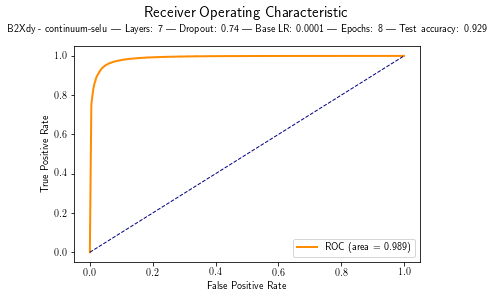

Plotting signal efficiency versus background rejection


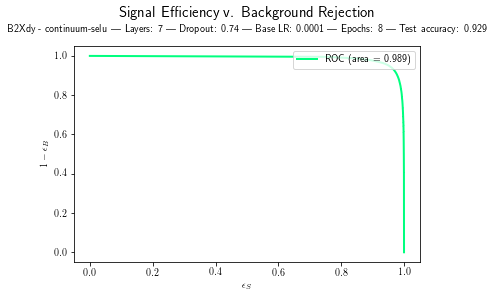

Inference complete. Duration: 9.03982 s


In [8]:
import os
ckpt = tf.train.get_checkpoint_state(directories.checkpoints)
vDNN = vanillaDNN(config, training = False)
labels, preds, output = vDNN.predict(ckpt)

# Add predictions to test set as a new column, save as HDF5
output = pd.Series(output, name='probs')
test = pd.concat([pdf1, output], axis=1)

In [9]:
output

0         9.345390e-01
1         1.000000e+00
2         0.000000e+00
3         0.000000e+00
4         8.583705e-35
5         0.000000e+00
6         0.000000e+00
7         1.000000e+00
8         0.000000e+00
9         6.897035e-22
10        1.000000e+00
11        9.314652e-01
12        1.000000e+00
13        1.000000e+00
14        1.000000e+00
15        2.619639e-07
16        1.101381e-32
17        9.320296e-20
18        1.651990e-04
19        1.000000e+00
20        1.000000e+00
21        1.000000e+00
22        0.000000e+00
23        3.899324e-35
24        1.641836e-16
25        1.000000e+00
26        1.000000e+00
27        1.000000e+00
28        6.911855e-01
29        1.000000e+00
              ...     
138278    1.000000e+00
138279    1.000000e+00
138280    9.999439e-01
138281    1.000000e+00
138282    1.000000e+00
138283    9.890485e-05
138284    1.000000e+00
138285    1.000000e+00
138286    1.000000e+00
138287    1.000000e+00
138288    1.000000e+00
138289    1.000000e+00
138290    1

In [9]:
test.shape

(347319, 108)

In [10]:
pdf1.shape

(347319, 107)

In [13]:
output

0         1.000000e+00
1         1.000000e+00
2         9.827306e-01
3         1.000000e+00
4         1.000000e+00
5         1.000000e+00
6         1.000000e+00
7         1.000000e+00
8         1.065946e-10
9         9.526831e-01
10        9.994755e-01
11        1.000000e+00
12        0.000000e+00
13        1.275826e-33
14        9.961402e-01
15        9.999176e-01
16        9.068767e-01
17        3.129100e-03
18        1.000000e+00
19        9.999944e-01
20        1.000000e+00
21        1.000000e+00
22        1.000000e+00
23        1.000000e+00
24        3.955720e-33
25        9.902784e-01
26        1.000000e+00
27        9.997016e-01
28        1.000000e+00
29        0.000000e+00
              ...     
347289    1.000000e+00
347290    9.946324e-01
347291    8.464706e-17
347292    1.000000e+00
347293    2.609681e-16
347294    1.000000e+00
347295    1.000000e+00
347296    9.960432e-01
347297    1.000000e+00
347298    0.000000e+00
347299    1.000000e+00
347300    9.977423e-01
347301    1

In [11]:
test

,BB_gamma_hel,B_CosTBTO,B_CosTBz,B_DeltaT,B_R2,B_TagVPvalue,B_TagVex,B_TagVey,B_TagVez,B_TagVx,...,B_useCMSFrame_bodaughterSumOf_bopz_bc_bc,mbc,deltae,daughterInvM,evtNum,MCtype,nCands,channel,labels,probs
0,-1.588105,-0.566125,2.060708,0.006763,-1.170962,1.273394,-0.012045,0.042164,-0.012057,-0.005894,...,0.024435,5.277649,-0.002986,1.657435,3.249500e+04,7.0,1.0,0.0,1.0,1.000000e+00
1,-1.583511,0.326212,1.965546,0.000565,-0.139086,-0.987356,-0.012026,0.042042,-0.012054,0.023391,...,-0.396096,5.280044,0.024862,1.672550,4.530700e+04,7.0,1.0,0.0,1.0,1.000000e+00
2,-1.582909,-1.306332,2.205411,0.021708,-1.382867,-0.158151,-0.011995,0.042215,-0.011983,-0.031475,...,1.046946,5.279857,-0.106811,2.220620,1.386191e+08,0.0,1.0,11.0,0.0,9.827306e-01
3,-1.581905,-0.050490,1.774217,-0.000200,0.090453,-1.093808,-0.011944,0.042215,-0.011924,-0.002600,...,-1.155154,5.272421,-0.122822,2.332373,2.621646e+08,2.0,2.0,7.0,0.0,1.000000e+00
4,-1.575761,-0.710063,1.977314,0.008272,-1.013066,0.622739,-0.012038,0.042200,-0.012050,-0.000999,...,-0.647386,5.281581,0.055017,2.082395,7.297000e+03,7.0,1.0,6.0,1.0,1.000000e+00
5,-1.574043,0.709838,1.887089,0.022262,-0.304458,0.978461,-0.012024,0.042213,-0.012022,-0.001381,...,-0.462639,5.273503,-0.166270,2.049185,3.964600e+04,7.0,1.0,1.0,1.0,1.000000e+00
6,-1.573475,-0.185380,2.025063,0.011435,-0.784249,1.865040,-0.012011,0.042205,-0.012009,0.003061,...,-0.210416,5.275576,0.008971,1.822210,1.213567e+09,0.0,2.0,11.0,0.0,1.000000e+00
7,-1.569883,-1.009027,2.177724,0.011549,-0.807890,1.904731,-0.012035,0.042192,-0.012047,-0.019559,...,0.878339,5.280567,0.179423,1.994851,2.481396e+08,0.0,2.0,5.0,0.0,1.000000e+00
8,-1.569604,-0.014816,2.004494,0.047200,-0.350407,-0.201612,-0.012022,0.042195,-0.012024,-0.017455,...,-0.578034,5.274578,-0.108732,0.953385,6.900000e+03,7.0,1.0,6.0,1.0,1.065946e-10
9,-1.569481,-1.954512,2.171281,-0.006076,-1.450575,-1.119552,-0.012044,0.042205,-0.012056,-0.001675,...,0.627990,5.277041,0.085580,1.227704,3.599200e+04,7.0,1.0,0.0,1.0,9.526831e-01


In [7]:
test.to_hdf(os.path.join(directories.checkpoints, '{}_preds.h5'.format(os.path.basename(directories.test))), key = 'df', format='t', data_columns=True)